In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import urbanpy as up
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
gdf_celdas = gpd.read_parquet("outputs/celdas_countries_wo_br.parquet")
print(f"{gdf_celdas.shape[0]} Cells loaded")

37673 Cells loaded


In [4]:
gdf_schools = gpd.read_parquet(
    "/Users/claudio/Documents/amazonia-bid/outputs/complete_schools.parquet"
)
print(f"{gdf_schools.shape[0]} Cells loaded")

260990 Cells loaded


In [5]:
gdf_schools.loc[:, "lat"] = gdf_schools["geometry"].y
gdf_schools.loc[:, "lon"] = gdf_schools["geometry"].x

In [6]:
gdf_celdas.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop_2020,polygon_id,geometry,index_countries,ADM0_EN,ADM0_PCODE,code
0,00001,urban_cluster,773.876615,1497.169295,2214.783282,2936.382639,3759.680520,4684.930881,5639.160211,6578.468722,7511.420150,8490.616181,02559-1-1,"POLYGON ((-79.52572 -5.57578, -79.52504 -5.567...",19.0,Peru,PE,per
1,00002,rural,127.349266,262.085135,409.920769,567.952579,738.324368,919.774243,1098.632136,1267.729462,1431.649299,1602.712228,07918-1-1,"POLYGON ((-79.50584 -5.33273, -79.5052 -5.3246...",19.0,Peru,PE,per
2,00003,rural,128.605609,273.402513,435.992956,620.728641,817.119036,1023.953282,1225.916293,1414.747791,1594.882633,1782.108802,06180-1-1,"POLYGON ((-79.52322 -5.66491, -79.52253 -5.656...",19.0,Peru,PE,per
3,00004,rural,127.938058,263.618495,410.432105,568.264752,735.777852,912.002276,1085.084391,1247.965492,1404.004588,1565.974205,06180-1-1,"POLYGON ((-79.52253 -5.65681, -79.52185 -5.648...",19.0,Peru,PE,per
4,00005,urban_cluster,176.856075,356.591034,548.408754,750.600224,1013.627816,1348.696712,1691.794096,2031.490143,2367.579627,2713.444995,02559-1-1,"POLYGON ((-79.51707 -5.59199, -79.51639 -5.583...",19.0,Peru,PE,per


In [7]:
gdf_celdas["code"].value_counts()

code
per    9741
bol    4558
ecu    3233
col     743
Name: count, dtype: int64

In [8]:
gdf_celdas["code"].isna().sum()

np.int64(19398)

In [9]:
gdf_celdas_peru = gdf_celdas[gdf_celdas["code"] == "per"]

In [10]:
gdf_schools["Pais"].value_counts()

Pais
Brasil       222936
Perú          22093
Bolivia        8209
Ecuador        3458
Colombia       2805
Venezuela       680
Guyana          466
Suriname        343
Name: count, dtype: int64

In [11]:
gdf_schools_peru = gdf_schools[gdf_schools["Pais"] == "Perú"]

In [12]:
assert (
    gdf_schools_peru.crs.to_string() == gdf_celdas.crs.to_string()
), "CRS do not match"

In [15]:
# start server
up.routing.start_osrm_server("south-america/peru", "foot")

Starting server ...
osrm_routing_server_south-america_peru_foot
Server was started succesfully


In [16]:
gdf_primary_schools_peru = gdf_schools_peru[gdf_schools_peru["EduNivelPrimaria"] == 1]
gdf_secondary_schools_peru = gdf_schools_peru[
    gdf_schools_peru["EduNivelSecundariaTotal"] == 1
]

In [17]:
total_schools = gdf_schools_peru.shape[0]
print("total # of schools in peru", gdf_schools_peru.shape[0])
print("primary:", gdf_primary_schools_peru.shape[0])
print("secondary:", gdf_secondary_schools_peru.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_peru.shape[0] + gdf_secondary_schools_peru.shape[0],
)

total # of schools in peru 22093
primary: 17481
secondary: 4612
add primary and secondary: 22093


In [18]:
gdf_celdas_peru_access_primaria = up.accessibility.travel_times(
    gdf_celdas_peru, gdf_primary_schools_peru, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/9741 [00:00<?, ?it/s]

In [19]:
gdf_celdas_peru_access_primaria

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,index_countries,ADM0_EN,ADM0_PCODE,code,lon,lat,nearest_primary_schools_ix,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,duration_to_nearest_primary_schools_label
0,00001,urban_cluster,773.876615,1497.169295,2214.783282,2936.382639,3759.680520,4684.930881,5639.160211,6578.468722,...,19.0,Peru,PE,per,-79.530381,-5.571733,7600,0.9042,10.846667,0-15
1,00002,rural,127.349266,262.085135,409.920769,567.952579,738.324368,919.774243,1098.632136,1267.729462,...,19.0,Peru,PE,per,-79.510522,-5.328681,11286,2.2246,26.700000,15-30
2,00003,rural,128.605609,273.402513,435.992956,620.728641,817.119036,1023.953282,1225.916293,1414.747791,...,19.0,Peru,PE,per,-79.527880,-5.660861,7560,11.7198,140.620000,>120
3,00004,rural,127.938058,263.618495,410.432105,568.264752,735.777852,912.002276,1085.084391,1247.965492,...,19.0,Peru,PE,per,-79.527193,-5.652758,7560,0.0266,0.320000,0-15
4,00005,urban_cluster,176.856075,356.591034,548.408754,750.600224,1013.627816,1348.696712,1691.794096,2031.490143,...,19.0,Peru,PE,per,-79.521730,-5.587937,7590,0.1765,2.120000,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14217,14218,rural,104.811272,220.811864,354.804257,512.238917,703.735842,939.221594,1211.228724,1507.372881,...,19.0,Peru,PE,per,-69.082884,-14.188886,6894,0.3659,4.393333,0-15
14221,14222,rural,263.647182,564.373913,918.776636,1346.033473,1866.073247,2505.801256,3243.598380,4044.801785,...,19.0,Peru,PE,per,-69.066556,-14.156151,7100,0.0928,1.116667,0-15
14225,14226,rural,1342.591525,2751.770038,4278.175126,5929.205165,8054.657130,10683.165158,13722.577114,17012.885448,...,19.0,Peru,PE,per,-69.048712,-14.115234,7107,0.4735,5.683333,0-15
14226,14227,rural,127.412471,259.922162,402.244202,555.299736,728.168274,920.775954,1144.595468,1386.938361,...,19.0,Peru,PE,per,-69.047180,-14.107051,7107,1.3926,16.710000,15-30


In [20]:
gdf_primary_schools_peru.reset_index()

,index,EduNivelPrimaria,EduNivelSecundariaTotal,Pais,unique_id,geometry,lat,lon
0,105990,1.0,0.0,Perú,perú504530,POINT (-73.7589 -14.6475),-14.647500,-73.758900
1,106495,1.0,0.0,Perú,perú785246,POINT (-73.6632 -14.4499),-14.449900,-73.663200
2,104749,1.0,0.0,Perú,perú364315,POINT (-73.97749 -14.27634),-14.276340,-73.977490
3,104380,1.0,0.0,Perú,perú363481,POINT (-74.0339 -14.2519),-14.251900,-74.033900
4,104341,1.0,0.0,Perú,perú363440,POINT (-74.0434 -14.2468),-14.246800,-74.043400
...,...,...,...,...,...,...,...,...
17476,80938,1.0,0.0,Perú,perú683011,POINT (-77.03612 -2.97532),-2.975320,-77.036124
17477,80320,1.0,0.0,Perú,perú730127,POINT (-77.07106 -2.87507),-2.875069,-77.071058
17478,80348,1.0,0.0,Perú,perú1535988,POINT (-77.0697 -2.82943),-2.829427,-77.069701
17479,78441,1.0,0.0,Perú,perú1628478,POINT (-77.2002 -2.9238),-2.923800,-77.200200


In [21]:
# Obtain the school unique_id and lat_lon
gdf_celdas_peru_access_primaria = pd.merge(
    gdf_celdas_peru_access_primaria,
    gdf_primary_schools_peru.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [22]:
gdf_celdas_peru_access_total = up.accessibility.travel_times(
    gdf_celdas_peru_access_primaria, gdf_secondary_schools_peru, "secondary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/9741 [00:00<?, ?it/s]

In [23]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_peru_access_total = pd.merge(
    gdf_celdas_peru_access_total,
    gdf_secondary_schools_peru.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [24]:
gdf_celdas_peru_access_total.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
0,00001,urban_cluster,773.876615,1497.169295,2214.783282,2936.382639,3759.680520,4684.930881,5639.160211,6578.468722,...,perú357798,-5.571330,-79.525782,2086,1.5603,18.718333,15-30,perú1095546,-5.568662,-79.521219
1,00002,rural,127.349266,262.085135,409.920769,567.952579,738.324368,919.774243,1098.632136,1267.729462,...,perú1558618,-5.331901,-79.509394,3105,5.0658,60.790000,60-90,perú635672,-5.338374,-79.493227
2,00003,rural,128.605609,273.402513,435.992956,620.728641,817.119036,1023.953282,1225.916293,1414.747791,...,perú1097377,-5.657290,-79.530899,2075,1.9473,23.363333,15-30,perú1275510,-5.665443,-79.524669
3,00004,rural,127.938058,263.618495,410.432105,568.264752,735.777852,912.002276,1085.084391,1247.965492,...,perú1097377,-5.657290,-79.530899,2075,13.6937,164.303333,>120,perú1275510,-5.665443,-79.524669
4,00005,urban_cluster,176.856075,356.591034,548.408754,750.600224,1013.627816,1348.696712,1691.794096,2031.490143,...,perú841189,-5.585445,-79.522845,2086,8.6950,104.343333,90-120,perú1095546,-5.568662,-79.521219


In [25]:
import seaborn as sns

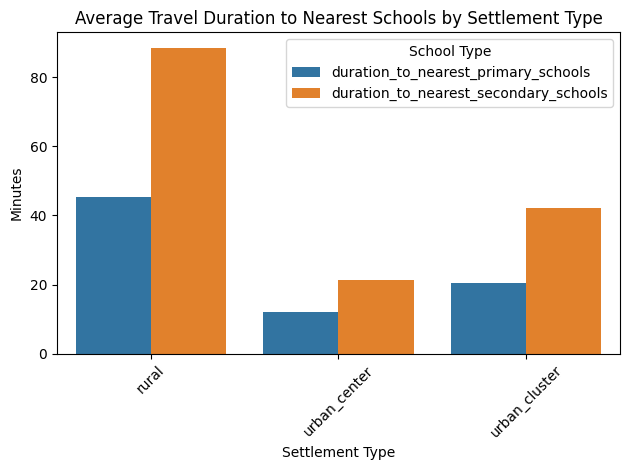

In [26]:
# Group by settlement type (smod) and calculate mean durations
grouped = (
    gdf_celdas_peru_access_total.groupby("smod")[
        ["duration_to_nearest_primary_schools", "duration_to_nearest_secondary_schools"]
    ]
    .mean()
    .reset_index()
)

# Plot
grouped_melted = grouped.melt(
    id_vars="smod", var_name="School Type", value_name="Avg Duration (min)"
)
sns.barplot(data=grouped_melted, x="smod", y="Avg Duration (min)", hue="School Type")
plt.title("Average Travel Duration to Nearest Schools by Settlement Type")
plt.ylabel("Minutes")
plt.xlabel("Settlement Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

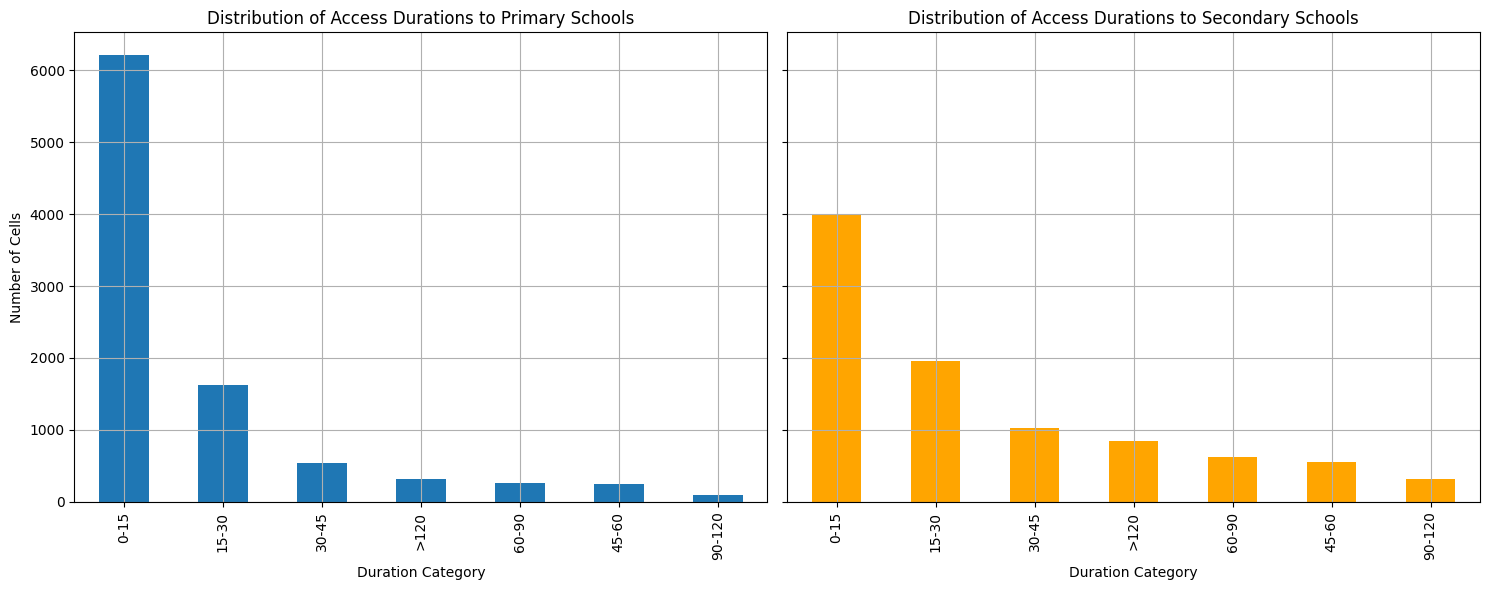

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for primary schools
gdf_celdas_peru_access_total[
    "duration_to_nearest_primary_schools_label"
].value_counts().plot(kind="bar", ax=axes[0])
axes[0].set_title("Distribution of Access Durations to Primary Schools")
axes[0].set_xlabel("Duration Category")
axes[0].set_ylabel("Number of Cells")
# axes[0].set_xticklabels(gdf_celdas_peru_access_total['duration_to_nearest_primary_schools_label'].unique().index, rotation=45)

# Plot for secondary schools
gdf_celdas_peru_access_total[
    "duration_to_nearest_secondary_schools_label"
].value_counts().plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Distribution of Access Durations to Secondary Schools")
axes[1].set_xlabel("Duration Category")
# axes[1].set_xticklabels(secondary_labels.index, rotation=45)

axes[0].grid(True)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
gdf_celdas_peru_access_total.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
0,00001,urban_cluster,773.876615,1497.169295,2214.783282,2936.382639,3759.680520,4684.930881,5639.160211,6578.468722,...,perú357798,-5.571330,-79.525782,2086,1.5603,18.718333,15-30,perú1095546,-5.568662,-79.521219
1,00002,rural,127.349266,262.085135,409.920769,567.952579,738.324368,919.774243,1098.632136,1267.729462,...,perú1558618,-5.331901,-79.509394,3105,5.0658,60.790000,60-90,perú635672,-5.338374,-79.493227
2,00003,rural,128.605609,273.402513,435.992956,620.728641,817.119036,1023.953282,1225.916293,1414.747791,...,perú1097377,-5.657290,-79.530899,2075,1.9473,23.363333,15-30,perú1275510,-5.665443,-79.524669
3,00004,rural,127.938058,263.618495,410.432105,568.264752,735.777852,912.002276,1085.084391,1247.965492,...,perú1097377,-5.657290,-79.530899,2075,13.6937,164.303333,>120,perú1275510,-5.665443,-79.524669
4,00005,urban_cluster,176.856075,356.591034,548.408754,750.600224,1013.627816,1348.696712,1691.794096,2031.490143,...,perú841189,-5.585445,-79.522845,2086,8.6950,104.343333,90-120,perú1095546,-5.568662,-79.521219


In [29]:
# Save the results
# gdf_celdas_peru_access.to_parquet("outputs/celdas_peru_access.parquet")
gdf_celdas_peru_access_total.to_parquet("outputs/celdas_peru_access_v2.parquet")

In [30]:
up.routing.stop_osrm_server("south-america/peru", "foot")

Server was stoped succesfully


In [31]:
gdf_celdas["code"].value_counts()

code
per    9741
bol    4558
ecu    3233
col     743
Name: count, dtype: int64

In [32]:
gdf_schools["Pais"].value_counts()

Pais
Brasil       222936
Perú          22093
Bolivia        8209
Ecuador        3458
Colombia       2805
Venezuela       680
Guyana          466
Suriname        343
Name: count, dtype: int64

In [33]:
up.routing.start_osrm_server("south-america/bolivia", "foot")

Starting server ...
osrm_routing_server_south-america_bolivia_foot
Server was started succesfully


In [34]:
# Select the data for the country
gdf_celdas_bol = gdf_celdas[gdf_celdas["code"] == "bol"]
gdf_schools_bol = gdf_schools[gdf_schools["Pais"] == "Bolivia"]

In [35]:
gdf_primary_schools_bol = gdf_schools_bol[gdf_schools_bol["EduNivelPrimaria"] == 1]
gdf_secondary_schools_bol = gdf_schools_bol[
    gdf_schools_bol["EduNivelSecundariaTotal"] == 1
]

In [36]:
print("total # of schools in bolivia", gdf_schools_bol.shape[0])
print("primary:", gdf_primary_schools_bol.shape[0])
print("secondary:", gdf_secondary_schools_bol.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_bol.shape[0] + gdf_secondary_schools_bol.shape[0],
)

total # of schools in bolivia 8209
primary: 7762
secondary: 2892
add primary and secondary: 10654


In [37]:
gdf_celdas_bol_access_primary = up.accessibility.travel_times(
    gdf_celdas_bol, gdf_primary_schools_bol, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/4558 [00:00<?, ?it/s]

In [38]:
# Obtain the school unique_id and lat_lon
gdf_celdas_bol_access_primary = pd.merge(
    gdf_celdas_bol_access_primary,
    gdf_primary_schools_bol.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [39]:
gdf_celdas_bol_access_total = up.accessibility.travel_times(
    gdf_celdas_bol_access_primary, gdf_secondary_schools_bol, "secondary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/4558 [00:00<?, ?it/s]

In [40]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_bol_access_total = pd.merge(
    gdf_celdas_bol_access_total,
    gdf_secondary_schools_bol.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [41]:
gdf_celdas_bol_access_total

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
13886,13887,urban_cluster,104.825494,223.638531,365.367907,532.631180,756.331140,1045.053330,1385.446574,1766.728589,...,boliviaID0013532,-10.947500,-69.564774,2804,1.6730,20.075000,15-30,boliviaID0013532,-10.947500,-69.564774
13955,13956,rural,27.399182,67.594099,122.557618,197.463636,290.430222,397.374168,536.507827,717.496279,...,boliviaID0013394,-11.134600,-69.215324,2802,1.0347,12.415000,0-15,boliviaID0013394,-11.134600,-69.215324
13992,13993,rural,1.727404,5.890069,19.501926,41.905899,93.348261,246.334796,451.661259,730.711286,...,boliviaID0013337,-11.280300,-69.069313,2790,0.2030,2.436667,0-15,boliviaID0013337,-11.280300,-69.069313
13997,13998,rural,10.727191,22.730851,37.306889,54.579556,88.652168,146.463163,221.419988,318.644286,...,boliviaID0013370,-11.185100,-69.028412,2797,0.5786,6.943333,0-15,boliviaID0013370,-11.185100,-69.028412
14080,14081,rural,41.429706,93.693430,159.420188,241.236232,339.788430,458.116727,644.444557,928.415508,...,boliviaID0013188,-11.879609,-68.986047,2773,0.5990,7.186667,0-15,boliviaID0013188,-11.879609,-68.986047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22469,22470,urban_cluster,93.922977,197.757289,312.123237,437.519823,583.077796,755.953718,980.522093,1273.611752,...,boliviaID005556,-17.840552,-60.730181,557,1.1586,13.905000,0-15,boliviaID005514,-17.848000,-60.732021
22576,22577,rural,155.625251,339.227191,548.237315,782.074933,1025.263018,1276.454597,1552.746162,1857.214344,...,boliviaID0010853,-16.271799,-60.078537,2425,0.9099,10.916667,0-15,boliviaID0010853,-16.271799,-60.078537
22581,22582,rural,60.459287,141.313057,242.839197,366.399697,510.253076,681.590978,900.504470,1181.788743,...,boliviaID005274,-17.908398,-60.365874,438,0.5050,6.065000,0-15,boliviaID005274,-17.908398,-60.365874
22582,22583,rural,41.911277,90.799781,145.520899,207.197284,278.057345,361.400419,467.012247,601.629627,...,boliviaID005274,-17.908398,-60.365874,438,1.0039,12.048333,0-15,boliviaID005274,-17.908398,-60.365874


In [42]:
up.routing.stop_osrm_server("south-america/bolivia", "foot")
# gdf_celdas_bol_access.head()

Server was stoped succesfully


In [43]:
# Save the results
# gdf_celdas_bol_access.to_parquet("outputs/celdas_bol_access.parquet")
gdf_celdas_bol_access_total.to_parquet("outputs/celdas_bol_access_v2.parquet")

In [44]:
# Select the data for the country
gdf_celdas_ecu = gdf_celdas[gdf_celdas["code"] == "ecu"]
gdf_schools_ecu = gdf_schools[gdf_schools["Pais"] == "Ecuador"]

In [45]:
gdf_primary_schools_ecu = gdf_schools_ecu[gdf_schools_ecu["EduNivelPrimaria"] == 1]
gdf_secondary_schools_ecu = gdf_schools_ecu[
    gdf_schools_ecu["EduNivelSecundariaTotal"] == 1
]

In [46]:
print("total # of schools in ecuador", gdf_schools_ecu.shape[0])
print("primary:", gdf_primary_schools_ecu.shape[0])
print("secondary:", gdf_secondary_schools_ecu.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_ecu.shape[0] + gdf_secondary_schools_ecu.shape[0],
)

total # of schools in ecuador 3458
primary: 3448
secondary: 3458
add primary and secondary: 6906


In [47]:
# start server
up.routing.start_osrm_server("south-america/ecuador", "foot")

Starting server ...
osrm_routing_server_south-america_ecuador_foot
Server was started succesfully


In [48]:
gdf_celdas_ecu_access_primary = up.accessibility.travel_times(
    gdf_celdas_ecu, gdf_primary_schools_ecu, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/3233 [00:00<?, ?it/s]

In [49]:
# Obtain the school unique_id and lat_lon
gdf_celdas_ecu_access_primary = pd.merge(
    gdf_celdas_ecu_access_primary,
    gdf_primary_schools_ecu.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [68]:
gdf_celdas_ecu_access_total = up.accessibility.travel_times(
    gdf_celdas_ecu_access_primary, gdf_secondary_schools_ecu, "secondary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/3233 [00:00<?, ?it/s]

In [69]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_ecu_access_total = pd.merge(
    gdf_celdas_ecu_access_total,
    gdf_secondary_schools_ecu.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [70]:
# gdf_celdas_ecu_access.to_parquet("outputs/celdas_ecu_access.parquet")
gdf_celdas_ecu_access_total.to_parquet("outputs/celdas_ecu_access_v2.parquet")

In [53]:
up.routing.stop_osrm_server("south-america/ecuador", "foot")

Server was stoped succesfully


In [71]:
gdf_celdas_ecu_access_total.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
84,00085,rural,85.479595,184.973059,296.131973,418.764989,551.569609,691.882748,836.855925,987.011373,...,ecuador11B00010,-3.740023,-79.264214,1239,0.0,0.0,NaN,ecuador11B00010,-3.740023,-79.264214
87,00088,rural,93.878211,210.439661,353.306180,529.011354,715.838696,909.991281,1110.126446,1316.910593,...,ecuador11H00271,-3.951628,-79.241480,1208,0.0,0.0,NaN,ecuador11H00271,-3.951628,-79.241480
88,00089,rural,176.113480,375.710528,597.528510,838.928523,1093.229792,1355.052377,1625.570543,1905.758749,...,ecuador11H00389,-3.761944,-79.255472,1237,0.0,0.0,NaN,ecuador11H00389,-3.761944,-79.255472
89,00090,rural,77.620575,171.361459,285.519478,414.177920,549.361239,688.282906,831.818395,980.726231,...,ecuador11B00022,-3.751518,-79.269610,1238,0.0,0.0,NaN,ecuador11B00022,-3.751518,-79.269610
90,00091,rural,159.629951,344.976295,580.021068,840.263582,1115.204644,1399.140380,1693.594081,1999.579572,...,ecuador11B00071,-3.734500,-79.263806,1251,0.0,0.0,NaN,ecuador11B00071,-3.734500,-79.263806


In [55]:
# Select the data for the country
gdf_celdas_col = gdf_celdas[gdf_celdas["code"] == "col"]
gdf_schools_col = gdf_schools[gdf_schools["Pais"] == "Colombia"]

In [76]:
gdf_primary_schools_col = gdf_schools_col[gdf_schools_col["EduNivelPrimaria"] == 1]
gdf_secondary_schools_col = gdf_schools_col[
    gdf_schools_col["EduNivelSecundariaTotal"] == 1
]

In [77]:
print("total # of schools in colombia", gdf_schools_col.shape[0])
print("primary:", gdf_primary_schools_col.shape[0])
print("secondary:", gdf_secondary_schools_col.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_col.shape[0] + gdf_secondary_schools_col.shape[0],
)

total # of schools in colombia 2805
primary: 2750
secondary: 534
add primary and secondary: 3284


In [78]:
# start server
up.routing.start_osrm_server("south-america/colombia", "foot")

Starting server ...
osrm_routing_server_south-america_colombia_foot
Server was started succesfully


In [79]:
gdf_celdas_col_access_primary = up.accessibility.travel_times(
    gdf_celdas_col, gdf_primary_schools_col, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/743 [00:00<?, ?it/s]

In [80]:
# Obtain the school unique_id and lat_lon
gdf_celdas_col_access_primary = pd.merge(
    gdf_celdas_col_access_primary,
    gdf_primary_schools_col.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [81]:
gdf_celdas_col_access_total = up.accessibility.travel_times(
    gdf_celdas_col_access_primary, gdf_secondary_schools_col, "secondary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/743 [00:00<?, ?it/s]

In [82]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_col_access_total = pd.merge(
    gdf_celdas_col_access_total,
    gdf_secondary_schools_col.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [83]:
# gdf_celdas_ecu_access.to_parquet("outputs/celdas_ecu_access.parquet")
gdf_celdas_col_access_total.to_parquet("outputs/celdas_ecu_access_v2.parquet")

In [84]:
up.routing.stop_osrm_server("south-america/colombia", "foot")

Server was stoped succesfully


In [85]:
gdf_celdas_col_access_total.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
4682,04683,rural,101.704695,229.546216,388.682558,582.972243,807.305308,1059.673228,1344.063069,1654.596122,...,colombia252356001141,0.666154,-77.534782,529,0.6770,8.126667,0-15,colombia252356000535,0.671354,-77.537483
4683,04684,rural,89.519654,195.215252,319.235568,462.959048,645.170395,863.227332,1108.610343,1376.274736,...,colombia252356000535,0.671354,-77.537483,529,0.5362,6.433333,0-15,colombia252356000535,0.671354,-77.537483
5023,05024,rural,47.303123,107.683166,183.666051,278.552089,429.162396,640.178110,873.454993,1123.773421,...,colombia252356800116,0.481138,-77.165123,525,0.0348,0.418333,0-15,colombia252356800116,0.481138,-77.165123
5041,05042,rural,31.381850,70.445735,118.419627,176.020042,242.583121,316.778921,399.484287,488.545973,...,colombia252001000160,1.148790,-77.157204,533,3.3674,40.405000,30-45,colombia452001002528,1.162071,-77.156952
5042,05043,rural,174.800534,383.174638,629.383391,914.942850,1196.964236,1473.051285,1765.862977,2067.461001,...,colombia252001000160,1.148790,-77.157204,533,2.5364,30.438333,30-45,colombia452001002528,1.162071,-77.156952


In [87]:
# Read and concatenate them into a single GeoDataFrame
gdf_combined_comp = gpd.GeoDataFrame(
    pd.concat(
        [
            gdf_celdas_bol_access_total,
            gdf_celdas_col_access_total,
            gdf_celdas_ecu_access_total,
            gdf_celdas_peru_access_total,
        ],
        ignore_index=True,
    )
)

# Display the combined GeoDataFrame
gdf_combined_comp.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
0,13887,urban_cluster,104.825494,223.638531,365.367907,532.631180,756.331140,1045.053330,1385.446574,1766.728589,...,boliviaID0013532,-10.947500,-69.564774,2804,1.6730,20.075000,15-30,boliviaID0013532,-10.947500,-69.564774
1,13956,rural,27.399182,67.594099,122.557618,197.463636,290.430222,397.374168,536.507827,717.496279,...,boliviaID0013394,-11.134600,-69.215324,2802,1.0347,12.415000,0-15,boliviaID0013394,-11.134600,-69.215324
2,13993,rural,1.727404,5.890069,19.501926,41.905899,93.348261,246.334796,451.661259,730.711286,...,boliviaID0013337,-11.280300,-69.069313,2790,0.2030,2.436667,0-15,boliviaID0013337,-11.280300,-69.069313
3,13998,rural,10.727191,22.730851,37.306889,54.579556,88.652168,146.463163,221.419988,318.644286,...,boliviaID0013370,-11.185100,-69.028412,2797,0.5786,6.943333,0-15,boliviaID0013370,-11.185100,-69.028412
4,14081,rural,41.429706,93.693430,159.420188,241.236232,339.788430,458.116727,644.444557,928.415508,...,boliviaID0013188,-11.879609,-68.986047,2773,0.5990,7.186667,0-15,boliviaID0013188,-11.879609,-68.986047


In [ ]:
# gdf_combined_comp["nivel_educativo"] = gdf_combined_comp.apply(
#     lambda x: (
#         "Primaria"
#         if x["EduNivelPrimaria"] == 1
#         else "Secundaria" if x["EduNivelSecundariaTotal"] == 1 else "Ninguno"
#     ),
#     axis=1,
# )

In [ ]:
# gdf_combined_comp["nivel_educativo"].value_counts()

In [88]:
# Save the combined GeoDataFrame to a new file
gdf_combined_comp.to_parquet("outputs/celdas_combined_access_v2.parquet")

In [89]:
gdf_schools

,EduNivelPrimaria,EduNivelSecundariaTotal,Pais,unique_id,geometry,lat,lon
0,1.0,0.0,Brasil,brasil11000023,POINT (-63.85401 -8.75846),-8.758459,-63.854011
1,0.0,0.0,Brasil,brasil11000040,POINT (-63.88392 -8.79373),-8.793730,-63.883919
2,1.0,1.0,Brasil,brasil11000058,POINT (-63.90199 -8.76073),-8.760734,-63.901986
3,1.0,1.0,Brasil,brasil11000082,POINT (-63.89618 -8.7652),-8.765205,-63.896177
4,1.0,1.0,Brasil,brasil11000104,POINT (-63.87547 -8.76863),-8.768633,-63.875471
...,...,...,...,...,...,...,...
16729,1.0,0.0,Colombia,colombia252001000160,POINT (-77.1572 1.14879),1.148790,-77.157204
16744,1.0,0.0,Colombia,colombia252001003959,POINT (-77.15452 1.16188),1.161877,-77.154518
16734,0.0,1.0,Colombia,colombia452001002528,POINT (-77.15695 1.16207),1.162071,-77.156952
16732,1.0,0.0,Colombia,colombia252001001671,POINT (-77.15704 1.16306),1.163060,-77.157036


In [ ]:
plotly.offline.init_notebook_mode()

In [ ]:
fig = up.plotting.choropleth_map(
    huancabamba_access,
    "pop_2020",
    title="Estimated Population - 2020",
    width=400,
    height=400,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

fig.show()

In [ ]:
# Get ordered category labels
category_orders = (
    huancabamba_access["duration_to_nearest_schools_label"].unique().sort_values()
)
category_orders.categories

In [ ]:
fig = up.plotting.choropleth_map(
    huancabamba_access,
    color_column="duration_to_nearest_schools_label",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    category_orders={"duration_to_nearest_schools_label": category_orders},
    labels={"duration_to_nearest_schools_label": "Minutes"},
    title="Travel Time to Nearest School",
    width=400,
    height=400,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0))

# Remove the hexagon outlines to make the map clearer
fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
celdas_peru = gdf_celdas[gdf_celdas.intersects(peru.geometry[0])]

In [ ]:
celdas_peru.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

peru.plot(ax=ax, facecolor="none", edgecolor="black")
celdas_peru.plot(
    "pop_2020", cmap="viridis", legend=True, ax=ax, alpha=1, edgecolor="none"
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=peru.crs)

In [ ]:
# Schools
peru_schools, _ = up.download.overpass(
    type_of_data="node",
    mask=peru,
    query={
        "amenity": "school",
    },
)

In [ ]:
peru_schools.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

peru.plot(ax=ax, facecolor="none", edgecolor="black")

peru_schools.plot(ax=ax, color="red", markersize=0.001)

celdas_peru.plot(
    "pop_2020", cmap="viridis", legend=True, ax=ax, alpha=1, edgecolor="none"
)


# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=peru.crs)

In [ ]:
# start server
up.routing.start_osrm_server("peru", "south-america", "foot")

In [ ]:
peru_access = up.accessibility.travel_times(celdas_peru, peru_schools, "schools")

In [ ]:
peru_access.head()

In [ ]:
up.routing.stop_osrm_server("peru", "south-america", "foot")

In [ ]:
for idx, cell in peru_access[
    peru_access["distance_to_nearest_schools"].isna()
].iterrows():
    print(cell)
    ax = gpd.GeoSeries(cell.geometry).plot(alpha=0.5)
    gpd.GeoSeries(peru_schools.loc[cell.nearest_schools_ix, "geometry"]).plot(
        ax=ax, color="red", markersize=1
    )
    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=peru.crs)
    plt.show()

In [ ]:
plotly.offline.init_notebook_mode()

In [ ]:
fig = up.plotting.choropleth_map(
    peru_access,
    "pop_2020",
    title="Estimated Population - 2020",
    opacity=0.5,
    width=800,
    height=800,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

fig.show()

In [ ]:
# Get ordered category labels
category_orders = (
    huancabamba_access["duration_to_nearest_schools_label"].unique().sort_values()
)
category_orders.categories

In [ ]:
fig = up.plotting.choropleth_map(
    peru_access,
    color_column="duration_to_nearest_schools_label",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    category_orders={"duration_to_nearest_schools_label": category_orders},
    opacity=0.5,
    labels={"duration_to_nearest_schools_label": "Minutes"},
    title="Travel Time to Nearest School",
    width=800,
    height=800,
)

# Make space for the title
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

# Remove the hexagon outlines to make the map clearer
fig.update_traces(marker_line_width=0)

fig.show()